# Test of class Hamiltonian_QED



This notebook uses the class in 'Hamiltonian_QED_oprt.py' and 'Hamiltonian_QED_sym.py' that builds the Hamiltonian in terms of Pauli matrices.


In [27]:
import qiskit

In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
from scipy.sparse.linalg import eigsh
from qiskit.quantum_info import Statevector
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../") # go to parent dir
from itertools import permutations

In [30]:
from Hamiltonian_QED_sym import HamiltonianQED_sym
from Hamiltonian_QED_oprt import HamiltonianQED_oprt
from HC_Lattice import HCLattice
import primme

##### Class Hamilt

In [31]:
#class input parameters:
n_sites = [2,2]#how many sites for every dimension
g=0.5
fact_e_op = 1
fact_b_op = 1
m=3
omega=1
l=1
L=8
rotors = False
lambd = 1000
encoding = 'gray' #'ed'#
magnetic_basis=True
pbc=False
puregauge = True
static_charges_values =None#{(0,0):1,(1,0):-1}#TODO: no conditions applied, like charge conservation, etc. For conditions see func_qstatic_dist
display_hamiltonian=False
e_op_out_plus=False #if E out of site n has plus sign
sparse_pauli=True
#exact diagonalisation parameters:
threshold = 1e-12
num_eigs = 3

In [32]:
latt = HCLattice(n_sites,pbc=pbc)


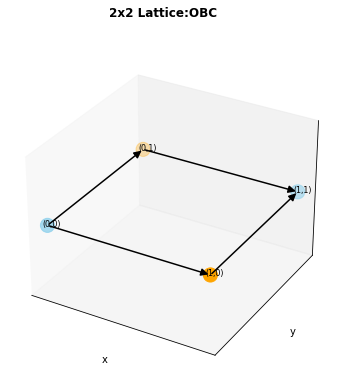

In [33]:

latt.draw_graph_func(gauss_law_fig=False,static_charges=static_charges_values)


In [34]:
#latt.func_qstatic_dist()#ch_val=1)
#[latt.draw_graph_func(gauss_law_fig=False,static_charges=st ) for st in latt.distances_coord]#,savefig_dir='.')

In [35]:
# Creating a configuration dictionary with common inputs
config = {
    'latt': latt,
    'n_sites': n_sites,
    'l':l,
    'L':L,
    'encoding':encoding,
    'magnetic_basis': magnetic_basis,
    'pbc': pbc,
    'puregauge': puregauge,
    'static_charges_values': None,
    'e_op_out_plus': e_op_out_plus
}
hamilt_sym = HamiltonianQED_sym(config,display_hamiltonian=False)
class_H_oprt = HamiltonianQED_oprt( config,hamilt_sym, sparse_pauli=sparse_pauli)

HamiltonianQED_sym: Initializing...
> Gauss law equations solved
> e_op_free and u_op_free built
Magnetic basis used for electric H
>> Gauss law applied and Hamiltonian built.  Execution time: 0.1548900604248047 seconds
HamiltonianQED_oprt: Initializing...
> e_op_free and u_op_free built
> Pauli strings built
Hamiltonian_el_pauli done
Hamiltonian B mag basis: done
>> Hamiltonian built.  Execution time: 4.272196054458618 seconds
>> Suppression term built.  Execution time: 0.001844167709350586 seconds


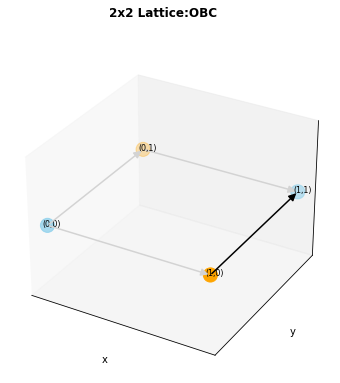

In [36]:
#only dynamical fields after Gauss law applied
latt.draw_graph_func(gauss_law_fig=True,e_op_free=class_H_oprt.e_op_free)#,savefig_dir='.')

In [37]:
def sparse_mem2(sparsem):
    """Return the memory in GiB of a sparse matrix"""
    return (sparsem.data.nbytes + sparsem.indptr.nbytes + sparsem.indices.nbytes)/1024**3

##### ED spectrum

In [38]:
import scipy.sparse as sp

In [39]:
Hamiltonian_Pauli_tot = class_H_oprt.get_hamiltonian(g_var=g, m_var=m, omega=omega,fact_b_op=fact_b_op,fact_e_op=fact_b_op,lambd=lambd)
#memory sparse matrix
#print((Hamiltonian_Pauli_tot.data.nbytes + Hamiltonian_Pauli_tot.indptr.nbytes + Hamiltonian_Pauli_tot.indices.nbytes)/1000**3,'Gb')
if encoding=='gray':
    Hamiltonian_Pauli_tot = Hamiltonian_Pauli_tot#.to_matrix(sparse=True)
    h_b_sparse = class_H_oprt.hamiltonian_mag_pauli#.to_matrix(sparse=True) #plaquette
elif encoding=='ed':
    Hamiltonian_Pauli_tot = sp.csr_matrix(Hamiltonian_Pauli_tot)
    h_b_sparse =sp.csr_matrix(class_H_oprt.hamiltonian_mag_pauli)
#spectrum, eigenvectors_matrix = eigsh(Hamiltonian_Pauli_tot,k=num_eigs,which="SA",ncv = 30)#
spectrum, eigenvectors_matrix =primme.eigsh(Hamiltonian_Pauli_tot,k=num_eigs,which="SA")#,ncv = 30)
#spectrum
idx = spectrum.argsort()
spectrum = spectrum[idx]
eigenvectors_matrix = eigenvectors_matrix[:,idx]
print(f'Spectrum of {latt.dims}D_'+'x'.join([str(i) for i in n_sites])+f'H with mbasis{magnetic_basis}puregauge{puregauge} pbc{pbc}_g{g}_l{l}_L{L}_factE{fact_e_op}_factB{fact_b_op}_m{m}_Omega{omega}, encoding:'+encoding)
for kk,evalu in enumerate(spectrum):
        if evalu<900:# only physical states, 1000 corresponds to factor of penalty term
                print(f'E_{kk}=',round(evalu,8))

if class_H_oprt.len_e_op != 0:
    eig0cj = sp.csr_matrix(eigenvectors_matrix[:,0]).transpose().conjugate()#.conj().T
    eig0= sp.csr_matrix(eigenvectors_matrix[:,0])
    plaq = (eig0*h_b_sparse*eig0cj/len(latt.plaq_list) ).toarray()[0][0].real
    #plaq = (eig0cj.dot((h_b_sparse).dot(eig0)).real)/len(latt.plaq_list)
    print(f'plaq={plaq}')



Spectrum of 2D_2x2H with mbasisTruepuregaugeTrue pbcFalse_g0.5_l1_L8_factE1_factB1_m3_Omega1, encoding:gray
E_0= -1.33717722
E_1= 6.45631389
E_2= 19.4210855
plaq=0.9696256488378332
